In [1]:
from pyspark.sql import SparkSession

In [2]:
#i strated a session and tested it

spark = SparkSession.builder \
    .appName("PhishTounsi_Urls").config("spark.task.maxFailures", "8") \
    .master("local")\
    .getOrCreate()


print(spark.version)

3.5.3


In [3]:
urls_df = spark.read.csv("balanced_urls.csv", header=True, inferSchema=True)#load dataset

urls_df.show(5)

+--------------------+-------+
|                urls|is_spam|
+--------------------+-------+
|https://www.googl...| benign|
|https://www.youtu...| benign|
|https://www.faceb...| benign|
|https://www.baidu...| benign|
|https://www.wikip...| benign|
+--------------------+-------+
only showing top 5 rows



In [4]:
from pyspark.sql.functions import when

urls_df =urls_df.withColumn("label",  when((urls_df["is_spam"] == "malicious"), 1).otherwise(0))#add label colum to conevert is_spam into binary

urls_df.show(20)

+--------------------+-------+-----+
|                urls|is_spam|label|
+--------------------+-------+-----+
|https://www.googl...| benign|    0|
|https://www.youtu...| benign|    0|
|https://www.faceb...| benign|    0|
|https://www.baidu...| benign|    0|
|https://www.wikip...| benign|    0|
|https://www.reddi...| benign|    0|
|https://www.yahoo...| benign|    0|
|https://www.googl...| benign|    0|
|  https://www.qq.com| benign|    0|
|https://www.amazo...| benign|    0|
|https://www.taoba...| benign|    0|
|https://www.twitt...| benign|    0|
|https://www.tmall...| benign|    0|
|https://www.googl...| benign|    0|
|  https://www.vk.com| benign|    0|
|https://www.live.com| benign|    0|
|https://www.insta...| benign|    0|
|https://www.sohu.com| benign|    0|
|https://www.sina....| benign|    0|
|  https://www.jd.com| benign|    0|
+--------------------+-------+-----+
only showing top 20 rows



In [5]:
from pyspark.sql.functions import col

# Remove duplicates
urls_df = urls_df.dropDuplicates(["urls"])

# Check for null values in the dataset
urls_df = urls_df.dropna()  # Dropping rows with null values


# Filter out invalid URLs
urls_df= urls_df.filter(col("urls").rlike(r"^https?://"))


In [6]:
from pyspark.sql.functions import length, regexp_replace, split

# Feature: URL length
urls_df = urls_df.withColumn("url_length", length(col("urls")))

# Feature: Special character count
urls_df= urls_df.withColumn("special_char_count", length(regexp_replace(col("urls"), "[^@#?=%&-]", "")))

# Feature: Presence of IP address
urls_df= urls_df.withColumn("contains_ip", when(col("urls").rlike(r"[0-9]+\.[0-9]+\.[0-9]+\.[0-9]+"), 1).otherwise(0))
urls_df.show(10)

+--------------------+---------+-----+----------+------------------+-----------+
|                urls|  is_spam|label|url_length|special_char_count|contains_ip|
+--------------------+---------+-----+----------+------------------+-----------+
|http:// 69.162.10...|malicious|    1|        23|                 0|          1|
|http:// babicz123...|malicious|    1|        27|                 0|          0|
|http:// highpower...|malicious|    1|        30|                 0|          0|
|http:// intent.no...|malicious|    1|        64|                 0|          0|
|http:// intent.no...|malicious|    1|        64|                 0|          0|
|http:// mister.no...|malicious|    1|        62|                 0|          0|
|       http://#NAME?|malicious|    1|        13|                 2|          0|
|http://%C3%87%C3%...|malicious|    1|       157|                41|          0|
|http://%supdate_%...|malicious|    1|        22|                 2|          0|
|http://.png&w=800...|malici

In [7]:
from pyspark.sql.functions import lower

# Convert URLs to lowercase
urls_df= urls_df.withColumn("urls", lower(col("urls")))

# Filter out short URLs (e.g., less than 10 characters)
urls_df =urls_df.filter(length(col("urls")) > 10)


In [8]:
from pyspark.sql.functions import length, when, split, col, size

# Feature: Domain length
urls_df = urls_df.withColumn(
    "domain_length", 
    length(split(col("urls"), "/")[2])  # Get the domain part of the URL
)

# Feature: Suspicious TLDs
urls_df= urls_df.withColumn(
    "suspicious_tld", 
    when(col("urls").rlike(r"\.(xyz|info|tk|top|icu)$"), 1).otherwise(0)
)

# Feature: HTTPS usage
urls_df =urls_df.withColumn(
    "uses_https", 
    when(col("urls").startswith("https"), 1).otherwise(0)
)

# Feature: Subdomain count
urls_df= urls_df.withColumn(
    "subdomain_count", 
    size(split(col("urls"), "\\.")) - 2  # Subdomains are the parts before the domain, adjust accordingly
)

# Feature: Presence of phishing keywords
urls_df =urls_df.withColumn(
    "phishing_keywords", 
    when(col("urls").rlike(r"(login|verify|secure|bank|update)"), 1).otherwise(0)
)

# Feature: URL encoding
urls_df =urls_df.withColumn(
    "url_encoded", 
    when(col("urls").rlike(r"%[0-9A-Fa-f]{2}"), 1).otherwise(0)
)

# Show the resulting DataFrame with the new features
urls_df.show(10)


+--------------------+---------+-----+----------+------------------+-----------+-------------+--------------+----------+---------------+-----------------+-----------+
|                urls|  is_spam|label|url_length|special_char_count|contains_ip|domain_length|suspicious_tld|uses_https|subdomain_count|phishing_keywords|url_encoded|
+--------------------+---------+-----+----------+------------------+-----------+-------------+--------------+----------+---------------+-----------------+-----------+
|http:// 69.162.10...|malicious|    1|        23|                 0|          1|           15|             0|         0|              2|                0|          0|
|http:// babicz123...|malicious|    1|        27|                 0|          0|           19|             0|         0|              1|                0|          0|
|http:// highpower...|malicious|    1|        30|                 0|          0|           23|             0|         0|              0|                0|          0

In [9]:
from pyspark.ml.feature import VectorAssembler

# Define the list of feature columns to be included in the model
feature_columns = [
    "url_length", "special_char_count", "contains_ip", "domain_length",
    "suspicious_tld", "uses_https", "subdomain_count", "phishing_keywords", "url_encoded"
]

# Assemble features into a single vector column
assembler = VectorAssembler(inputCols=feature_columns, outputCol="features")
urls_df = assembler.transform(urls_df)


In [10]:
# Split the dataset into training and testing sets (80% train, 20% test)
train_ratio = 0.8
urls_train_df, urls_test_df =urls_df.randomSplit([train_ratio, 1 - train_ratio], seed=42)

# Check the count of each label (0 and 1) in the training set
train_counts = urls_train_df.groupBy("label").count()

# Check the count of each label (0 and 1) in the testing set
test_counts = urls_test_df.groupBy("label").count()

# Show the counts for both training and testing sets
train_counts.show()
test_counts.show()

+-----+------+
|label| count|
+-----+------+
|    1|196439|
|    0|253144|
+-----+------+

+-----+-----+
|label|count|
+-----+-----+
|    1|49377|
|    0|63074|
+-----+-----+



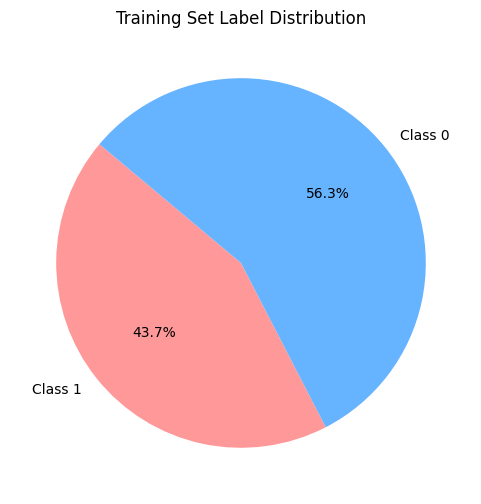

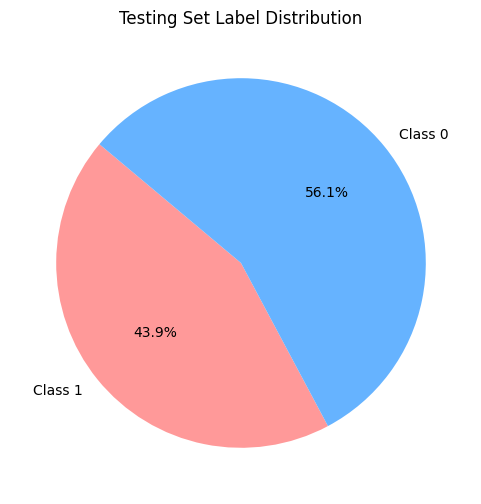

In [11]:
import matplotlib.pyplot as plt

# Convert the results into dictionaries for easier visualization
train_counts_dict = {row["label"]: row["count"] for row in train_counts.collect()}
test_counts_dict = {row["label"]: row["count"] for row in test_counts.collect()}

# Prepare data for the pie chart
def plot_pie_chart(data_dict, title):
    labels = [f"Class {label}" for label in data_dict.keys()]
    sizes = data_dict.values()

    plt.figure(figsize=(6, 6))
    plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=140, colors=["#ff9999", "#66b3ff"])
    plt.title(title)
    plt.show()

# Plot pie charts for training and testing sets
plot_pie_chart(train_counts_dict, "Training Set Label Distribution")
plot_pie_chart(test_counts_dict, "Testing Set Label Distribution")



In [12]:
from pyspark.ml.classification import GBTClassifier

# Initialize the GBTClassifier
gbt = GBTClassifier(labelCol="label", featuresCol="features", maxIter=50, maxDepth=5)

# Train the model
gbt_model = gbt.fit(urls_train_df)


In [13]:
# Generate predictions
predictions = gbt_model.transform(urls_test_df)

# Display some predictions
predictions.select("features", "label", "rawPrediction", "probability", "prediction").show(10, truncate=False)


+---------------------------------------+-----+----------------------------------------+-----------------------------------------+----------+
|features                               |label|rawPrediction                           |probability                              |prediction|
+---------------------------------------+-----+----------------------------------------+-----------------------------------------+----------+
|(9,[0,3],[30.0,23.0])                  |1    |[-1.9084877786088197,1.9084877786088197]|[0.021520885558318166,0.9784791144416818]|1.0       |
|(9,[0,1,3,6],[13.0,2.0,6.0,-1.0])      |1    |[-1.9084877786088252,1.9084877786088252]|[0.021520885558317934,0.9784791144416821]|1.0       |
|(9,[0,1,3,7],[22.0,2.0,15.0,1.0])      |1    |[-1.9084877786085725,1.9084877786085725]|[0.021520885558328574,0.9784791144416715]|1.0       |
|(9,[0,2,3,6],[44.0,1.0,25.0,5.0])      |1    |[-1.9084877786085461,1.9084877786085461]|[0.021520885558329688,0.9784791144416704]|1.0       |
|(9,[0

In [14]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator, MulticlassClassificationEvaluator

# Initialize evaluators
evaluator_binary = BinaryClassificationEvaluator(labelCol="label", metricName="areaUnderROC")
evaluator_multi = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction")

# Compute accuracy
correct_predictions = predictions.filter(predictions.label == predictions.prediction).count()
total_data = predictions.count()
accuracy = correct_predictions / total_data

# Compute precision, recall, F1-score
precision = evaluator_multi.evaluate(predictions, {evaluator_multi.metricName: "weightedPrecision"})
recall = evaluator_multi.evaluate(predictions, {evaluator_multi.metricName: "weightedRecall"})
f1_score = evaluator_multi.evaluate(predictions, {evaluator_multi.metricName: "f1"})

# Compute ROC-AUC
roc_auc = evaluator_binary.evaluate(predictions)

# Print evaluation metrics
print(f"Test Accuracy: {accuracy:.2f}")
print(f"Test Precision: {precision:.2f}")
print(f"Test Recall: {recall:.2f}")
print(f"Test F1-Score: {f1_score:.2f}")
print(f"Test ROC-AUC: {roc_auc:.2f}")


Test Accuracy: 0.97
Test Precision: 0.98
Test Recall: 0.97
Test F1-Score: 0.97
Test ROC-AUC: 0.99


Correct Predictions: 109549 (97.42%)
  Correct Label 0: 62943
  Correct Label 1: 46606
Incorrect Predictions: 2902 (2.58%)
  Incorrect Label 0: 131
  Incorrect Label 1: 2771


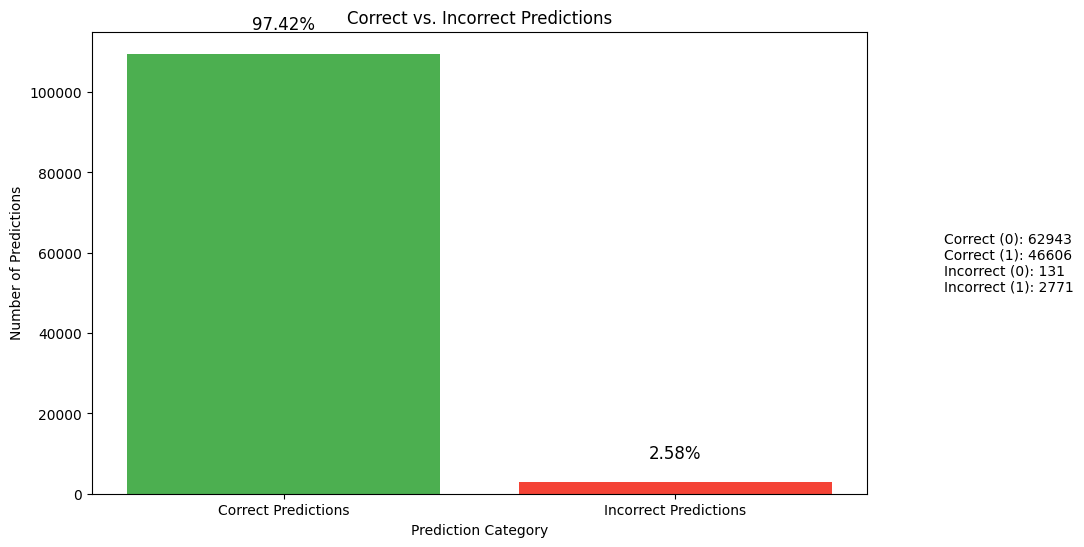

In [15]:
import matplotlib.pyplot as plt

# Calculate counts for correct and incorrect predictions
correct_predictions = predictions.filter(predictions.label == predictions.prediction)
incorrect_predictions = predictions.filter(predictions.label != predictions.prediction)

# Count the total number of predictions
total_predictions = predictions.count()

# Calculate overall counts
correct_count = correct_predictions.count()
incorrect_count = incorrect_predictions.count()

# Calculate percentages
correct_percentage = (correct_count / total_predictions) * 100
incorrect_percentage = (incorrect_count / total_predictions) * 100

# Count correct and incorrect predictions by label
correct_label_0 = correct_predictions.filter(correct_predictions.label == 0).count()
correct_label_1 = correct_predictions.filter(correct_predictions.label == 1).count()
incorrect_label_0 = incorrect_predictions.filter(incorrect_predictions.label == 0).count()
incorrect_label_1 = incorrect_predictions.filter(incorrect_predictions.label == 1).count()

# Print details
print(f"Correct Predictions: {correct_count} ({correct_percentage:.2f}%)")
print(f"  Correct Label 0: {correct_label_0}")
print(f"  Correct Label 1: {correct_label_1}")
print(f"Incorrect Predictions: {incorrect_count} ({incorrect_percentage:.2f}%)")
print(f"  Incorrect Label 0: {incorrect_label_0}")
print(f"  Incorrect Label 1: {incorrect_label_1}")

# Prepare data for bar chart
categories = ['Correct Predictions', 'Incorrect Predictions']
counts = [correct_count, incorrect_count]
percentages = [correct_percentage, incorrect_percentage]

# Bar chart
plt.figure(figsize=(10, 6))
bars = plt.bar(categories, counts, color=['#4CAF50', '#F44336'])

# Annotate bars with percentages
for bar, percentage in zip(bars, percentages):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 5000, f'{percentage:.2f}%', 
             ha='center', va='bottom', fontsize=12)

plt.title('Correct vs. Incorrect Predictions')
plt.ylabel('Number of Predictions')
plt.xlabel('Prediction Category')

# Add detailed breakdown as text annotation
details = (f"Correct (0): {correct_label_0}\n"
           f"Correct (1): {correct_label_1}\n"
           f"Incorrect (0): {incorrect_label_0}\n"
           f"Incorrect (1): {incorrect_label_1}")
plt.gca().text(1.1, 0.5, details, transform=plt.gca().transAxes, fontsize=10, verticalalignment='center')

plt.show()
